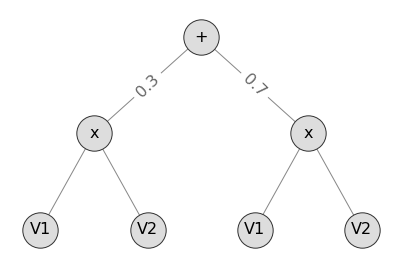

In [10]:
from spn.structure.leaves.parametric.Parametric import Categorical, Bernoulli
from spn.structure.Base import Sum, Product
from spn.structure.Base import assign_ids, rebuild_scopes_bottom_up
from spn.io.Graphics import plot_spn
import matplotlib.pyplot as plt
%matplotlib inline

p0 = Product(children=[Categorical(p=[0.3, 0.7], scope=1), Categorical(p=[0.4, 0.6], scope=2)])
p1 = Product(children=[Categorical(p=[0.5, 0.5], scope=1), Categorical(p=[0.6, 0.4], scope=2)])
s1 = Sum(weights=[0.3, 0.7], children=[p0, p1])
#p2 = Product(children=[Categorical(p=[0.2, 0.8], scope=0), s1])
#p3 = Product(children=[Categorical(p=[0.2, 0.8], scope=0), Categorical(p=[0.3, 0.7], scope=1)])
#p4 = Product(children=[p3, Categorical(p=[0.4, 0.6], scope=2)])
#spn = Sum(weights=[0.4, 0.6], children=[p2, p4])
spn = s1
assign_ids(spn)
rebuild_scopes_bottom_up(spn)

plot_spn(spn, 'simple_spn.pdf')

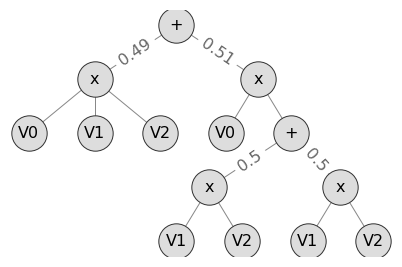

In [83]:
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.Base import Context
import itertools, random

table = list(itertools.product([1, 0], repeat=2))
p = [0.3, 0.3, 0.4, 0.8]
pdf = dict(zip(table, p))
data = []
for row in random.choices(population=table, k=10000, weights=[0.25]*4):
    data.append(row + tuple(np.random.binomial(1, size= 1, p=pdf[row])))

data = np.array(data)

spn = learn_parametric(data,
                       Context(parametric_types=[
                           Bernoulli, 
                           Bernoulli, 
                           Bernoulli]).add_domains(data),
                      ohe=True, rows="gmm", min_instances_slice=10)
plot_spn(spn)
import tikzplotlib

tikzplotlib.save("spntex.tex")

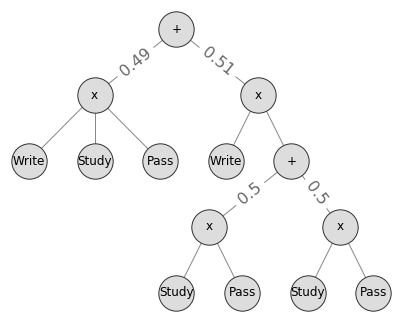

In [145]:
names = ['Write', 'Study', 'Pass']
from matplotlib.ticker import NullLocator
from networkx.drawing.nx_agraph import graphviz_layout

def _get_networkx_obj(spn):
    import networkx as nx
    from spn.structure.Base import Sum, Product, Leaf, get_nodes_by_type
    import numpy as np

    all_nodes = get_nodes_by_type(spn)
    logger.info(all_nodes)

    g = nx.Graph()

    labels = {}
    for n in all_nodes:

        if isinstance(n, Sum):
            label = "+"
        elif isinstance(n, Product):
            label = "x"
        else:
            label = names[n.scope[0]]
        g.add_node(n.id)
        labels[n.id] = label

        if isinstance(n, Leaf):
            continue
        for i, c in enumerate(n.children):
            edge_label = ""
            if isinstance(n, Sum):
                edge_label = np.round(n.weights[i], 2)
            g.add_edge(c.id, n.id, weight=edge_label)

    return g, labels


def draw_spn(spn):

    import networkx as nx
    from networkx.drawing.nx_pydot import graphviz_layout
    import matplotlib.pyplot as plt

    plt.clf()

    g, labels = _get_networkx_obj(spn)

    pos = graphviz_layout(g, prog="dot")
    ax = plt.gca()

    nx.draw(
        g,
        pos,
        with_labels=True,
        arrows=False,
        node_color="#DDDDDD",
        edge_color="#888888",
        width=1,
        node_size=1250,
        labels=labels,
        font_size=12,
    )
    ax.collections[0].set_edgecolor("#333333")
    edge_labels = nx.draw_networkx_edge_labels(
        g, pos=pos, edge_labels=nx.get_edge_attributes(g, "weight"), font_size=16, alpha=0.6
    )

    xpos = list(map(lambda p: p[0], pos.values()))
    ypos = list(map(lambda p: p[1], pos.values()))

    ax.set_xlim(min(xpos) - 20, max(xpos) + 20)
    ax.set_ylim(min(ypos) - 20, max(ypos) + 20)
    plt.tight_layout()
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    return plt

def plot_spn(spn, fname="plot.pdf"):
    plt = draw_spn(spn)
    plt.savefig(fname, bbox_inches="tight", pad_inches=0)

plt.figure(figsize = (6, 4.76))
plot_spn(spn, "example_spn.pdf")

In [102]:
import csi2
from spn.structure.Base import get_nodes_by_type, Product
names = ["V%d" % i for i in range(3)]
categorical = [True]*3
net = spn
train = data
def format_condition(condition):
    try:
        a, sign, b = condition.split(" ")
    except ValueError as e:
        raise ValueError("Some nodes don't have conditions. reduce min_impurity_decrease")
    
    if ((sign, b) == ('==', '1')) or ((sign, b) == ('!=', '0')):
        return ("%s" % (a))
    else:
        return ("~%s" % (a))

print ('#product nodes = ', len(get_nodes_by_type(net, (Product))))
net.n_instances = len(train)
csi2.annotate_spn(net, names, categorical, 
             min_impurity_decrease = 0.1, max_depth = 2)

rules = csi2.context_specific_independences(net, instance_threshold = 0)
csis = []
ac = []
cc = []
for i, rule in enumerate(rules):
    antecedent, consequent, *scores = rule
    A = csi2.format_antecedent(antecedent, format_condition)
    C = csi2.format_consequent(consequent)
    a_count = csi2.antecedent_count(A)
    c_count = csi2.consequent_count(C)
    ac.append(a_count)
    cc.append(c_count)
    csis.append ("{%s} => {%s} | %.2f, %.2f, %d | %d %d" % (A, C, *scores, a_count, c_count))
print ("%d, %.2f, %.2f" % (len(csis), np.mean(ac), np.mean(cc)))



#product nodes =  4
4, 1.50, 2.25


In [103]:
csis

['{V0} => {(V0), (V1), (V2)} | 1.00, 1.00, 4926 | 1 3',
 '{~V0} => {(V0), (V1,V2)} | 1.00, 1.00, 5074 | 1 2',
 '{[~V0] & [V1]} => {(V1), (V2)} | 1.00, 1.00, 2535 | 2 2',
 '{[~V0] & [~V1]} => {(V1), (V2)} | 1.00, 1.00, 2539 | 2 2']

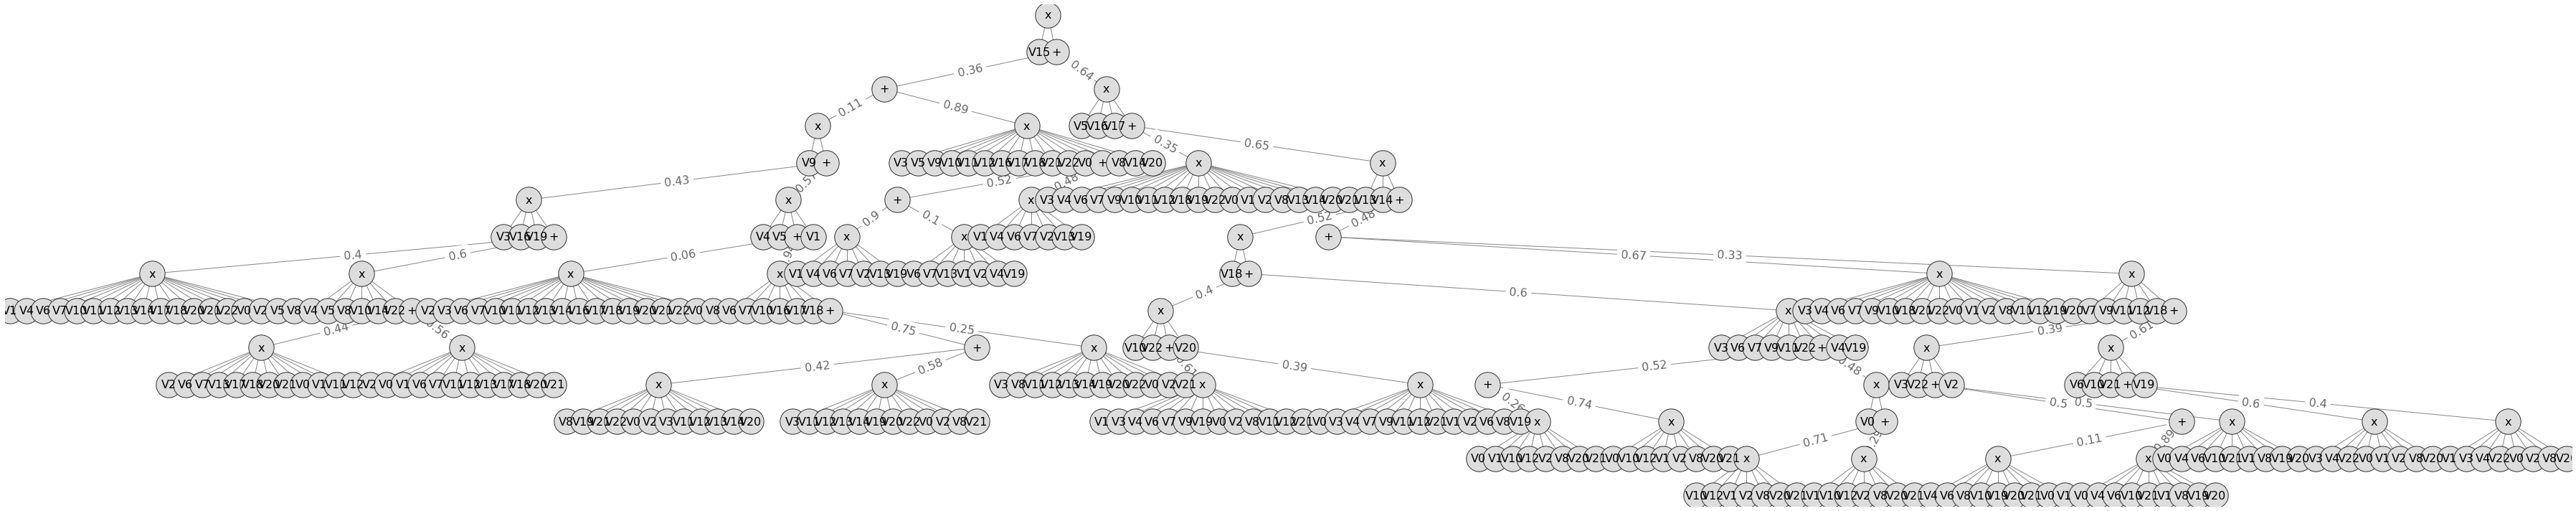

In [6]:
from joblib import load
from spn.io.Graphics import plot_spn
%matplotlib inline 
import matplotlib.pyplot as plt

net = load('models/precomputed/mushroom.joblib')
plt.figure(figsize=(50, 10))
plot_spn(net)

In [9]:
csi = load('explanations/precomputed/mushroom.joblib')
for rule in csi.rules():
    print (rule[0])

[['(habitat == 0) ^ (class == 0)'], ['stalk-shape == 0']]
[['(habitat == 0) ^ (class == 0)'], ['stalk-shape == 0'], ['stalk-color-below-ring != 5']]
[['(habitat == 0) ^ (class == 0)'], ['stalk-shape == 0'], ['stalk-color-below-ring != 5'], ['odor != 5']]
[['(habitat == 0) ^ (class == 0)'], ['stalk-shape == 0'], ['stalk-color-below-ring != 5'], ['odor == 5']]
[['(habitat == 0) ^ (class == 0)'], ['stalk-shape == 0'], ['stalk-color-below-ring != 5'], ['odor == 5'], ['cap-color == 1']]
[['(habitat == 0) ^ (class == 0)'], ['stalk-shape == 0'], ['stalk-color-below-ring != 5'], ['odor == 5'], ['cap-color != 1']]
[['(habitat == 0) ^ (class == 0)'], ['stalk-shape == 0'], ['stalk-color-below-ring == 5']]
[['(habitat == 0) ^ (class == 0)'], ['stalk-shape == 0'], ['stalk-color-below-ring == 5'], ['stalk-color-below-ring == 6']]
[['(habitat == 0) ^ (class == 0)'], ['stalk-shape == 0'], ['stalk-color-below-ring == 5'], ['stalk-color-below-ring != 6']]
[['(habitat == 0) ^ (class == 0)'], ['stalk-shap

In [11]:
len(csi.blocks)

2